<a href="https://colab.research.google.com/github/arpitj07/Tensorflow/blob/master/CIFAR_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive 
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd "/content/drive/My Drive/CIFAR-100"

/content/drive/My Drive/CIFAR-100


In [0]:
#!pip install kaggle
import json
import zipfile
import os

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.nn as nn

import math
import time


[Kaggle API access example ](https://colab.research.google.com/drive/1DofKEdQYaXmDWBzuResXWWvxhLgDeVyl#scrollTo=cDLXrqcNGlU7)

In [0]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle (3).json


{'kaggle.json': b'{"username":"arpitjain007","key":"cdbde8ffb2ec61e4949739228b931485"}'}

In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw------- 1 root root 68 Jan 10 11:58 kaggle.json


In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
# List available datasets.
#!kaggle datasets list

In [0]:
!kaggle datasets download -d pavansanagapati/cifar100

cifar100.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!unzip cifar100.zip

Archive:  cifar100.zip
replace cifar-100-python.tar.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: cifar-100-python.tar.gz  


**[Opening tar.gz file in Pyhton](https://community.esri.com/thread/189469-re-unzip-files-from-directory-tree?commentID=662700&et=watches.email.thread#comment-662700)**

--


In [0]:
import tarfile,fnmatch,os

rootPath = r"/content/drive/My Drive/CIFAR-100"
pattern = '*.tar.gz'


for root, dirs, files in os.walk(rootPath):
  for filename in fnmatch.filter(files, pattern):
    print(os.path.join(root, filename))
    
    tarfile.open(os.path.join(root, filename)).extractall(os.path.join(root, filename.split(".")[0]))

/content/drive/My Drive/CIFAR-100/cifar-100-python.tar.gz


In [0]:
import pickle

#Fucntion to load each batch as dict

def unpickle(file):
    
    fo = open(file, 'rb')
    dict = pickle.load(fo , encoding ='latin1')
    fo.close()
    return dict

In [0]:
train = unpickle("cifar-100-python/cifar-100-python/train")

test = unpickle("cifar-100-python/cifar-100-python/test")

In [0]:
print("train data shape:",train['data'].shape)

print("test data shape", test['data'].shape)

print("Labels shape", len(train['fine_labels']))

train data shape: (50000, 3072)
test data shape (10000, 3072)
Labels shape 50000


In [0]:
df_train = pd.DataFrame(train["data"])
df_train["image"] = df_train.as_matrix().tolist()
df_train.drop(range(3072),axis=1,inplace=True)

In [0]:
df_train.head()

,image
0,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
1,"[255, 253, 253, 253, 253, 253, 253, 253, 253, ..."
2,"[250, 248, 247, 248, 249, 249, 248, 248, 247, ..."
3,"[124, 131, 135, 138, 140, 144, 148, 152, 156, ..."
4,"[43, 32, 87, 127, 55, 48, 51, 87, 121, 113, 13..."


In [0]:
df_test = pd.DataFrame(test["data"])
df_test["image"] = df_test.as_matrix().tolist()
df_test.drop(range(3072),axis=1,inplace=True)


df_test.head()

,image
0,"[199, 196, 195, 195, 196, 197, 198, 198, 199, ..."
1,"[113, 88, 72, 63, 72, 100, 131, 149, 139, 132,..."
2,"[61, 61, 67, 62, 64, 63, 70, 73, 78, 88, 85, 7..."
3,"[93, 88, 104, 90, 74, 70, 70, 75, 77, 60, 61, ..."
4,"[80, 80, 82, 86, 92, 97, 96, 97, 98, 99, 100, ..."


**Data Preprocessing**

(50000, 32, 32, 3)
(10000, 32, 32, 3)


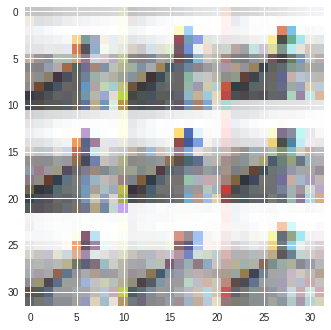

In [0]:
feautures = train['data'].reshape([len(df_train["image"]),32,32,3])
print(feautures.shape)

test_features = test['data'].reshape([len(df_test['image']),32,32,3])
print(test_features.shape)
plt.imshow(test_features[0])

In [0]:
Labels = train['fine_labels']
Test_Labels = test['fine_labels']

In [0]:
feautures = feautures/255
test_features = test_features/255

# **Helper Functions**

In [0]:
def one_hot_code(x):
    
    encoded = np.zeros((len(x),100))
    for idx , val in enumerate(x):
        encoded[idx][val]=1 
        
    return encoded

  
  
  
def mini_batches(X,Y, minibatch_size):
    
    m = X.shape[0]
    miniBatch_X = []
    miniBatch_Y = []
    permutation = list(np.random.permutation(m))
    
    #shuffling the data
    shuffled_X = X[permutation,:]
    shuffled_Y = Y[permutation,:]
    
    number_of_batches = math.floor(m/minibatch_size)
    
    for i in range(0, number_of_batches):
        
        minibatch_X = shuffled_X[ i*minibatch_size: (i+1)*minibatch_size , :]
        minibatch_Y = shuffled_Y[ i*minibatch_size: (i+1)*minibatch_size , :]
        
        miniBatch_X.append(minibatch_X) 
        miniBatch_Y.append(minibatch_Y)
        
        
    # handling last batch of the set
    
    if m% minibatch_size !=0:
        
        minibatch_X = shuffled_X[:(m-(number_of_batches*minibatch_size)) , :]
        minibatch_Y = shuffled_Y[:(m-(number_of_batches*minibatch_size)) , :]
        
        miniBatch_X.append(minibatch_X) 
        miniBatch_Y.append(minibatch_Y)
        
    return miniBatch_X , miniBatch_Y


In [0]:
#np.seterr(divide='ignore', invalid='ignore')

Labels = one_hot_code(Labels)
Test_Labels = one_hot_code(Test_Labels)

In [0]:
Test_Labels.shape

(10000, 100)

In [0]:
tf.reset_default_graph()

X= tf.placeholder(tf.float32 , shape = (None, 32,32,3) , name='X')
Y = tf.placeholder(tf.float32 , shape = (None, 100) , name='Y')


def model(input):
  
  conv1_filter = tf.Variable(tf.truncated_normal(shape=[3,3,3,32], mean=0 ,stddev=0.08))
  conv2_filter = tf.Variable(tf.truncated_normal(shape=[3,3,32,64], mean=0 ,stddev=0.08))
  conv3_filter = tf.Variable(tf.truncated_normal(shape=[5,5,64,128], mean=0 ,stddev=0.08))
  conv4_filter = tf.Variable(tf.truncated_normal(shape=[5,5,256,512], mean=0 ,stddev=0.08))
  

  conv_1 = nn.conv2d(input , conv1_filter , strides=[1,1,1,1], padding='SAME')
  conv_1= nn.relu(conv_1)
  conv_1_pool= nn.max_pool(conv_1 , ksize=[1,2,2,1] , strides=[1,2,2,1], padding='SAME')
  conv_1_bn = tf.layers.batch_normalization(conv_1_pool)
  
  
  conv_2 = nn.conv2d(conv_1_bn , conv2_filter , strides=[1,1,1,1], padding='SAME')
  conv_2= nn.relu(conv_2)
  conv_2_pool= nn.max_pool(conv_2 , ksize=[1,2,2,1] , strides=[1,2,2,1], padding='SAME')
  conv_2_bn = tf.layers.batch_normalization(conv_2_pool)
  
  
  conv_3 = nn.conv2d(conv_2_bn , conv3_filter , strides=[1,1,1,1], padding='SAME')
  conv_3= nn.relu(conv_3)
  conv_3_pool= nn.max_pool(conv_3 , ksize=[1,2,2,1] , strides=[1,2,2,1], padding='SAME')
  conv_3_bn = tf.layers.batch_normalization(conv_3_pool)
  
  
  '''conv_4 = nn.conv2d(conv_3_bn , conv4_filter , strides=[1,1,1,1], padding='SAME')
  conv_4= nn.relu(conv_4)
  conv_4_pool= nn.max_pool(conv_4 , ksize=[1,2,2,1] , strides=[1,2,2,1], padding='SAME')
  conv_4_bn = tf.layers.batch_normalization(conv_4_pool)'''
  
  
  flat = tf.contrib.layers.flatten(conv_3_bn)
  
  fc = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=128, activation_fn=tf.nn.relu)
  fc = tf.nn.dropout(fc, keep_prob=0.7)
  fc = tf.layers.batch_normalization(fc)
  
  fc2 = tf.contrib.layers.fully_connected(inputs=fc, num_outputs=256, activation_fn=tf.nn.relu)
  fc2 = tf.nn.dropout(fc2, keep_prob=0.7)
  fc2 = tf.layers.batch_normalization(fc2)
  
  '''fc3 = tf.contrib.layers.fully_connected(inputs=fc2, num_outputs=512, activation_fn=tf.nn.relu)
  fc3 = tf.nn.dropout(fc3, keep_prob=0.7)
  fc3 = tf.layers.batch_normalization(fc3)
  
  fc4 = tf.contrib.layers.fully_connected(inputs=fc3, num_outputs=1024, activation_fn=tf.nn.relu)
  fc4 = tf.nn.dropout(fc4, keep_prob=0.7)
  fc4 = tf.layers.batch_normalization(fc4)'''
  
  Out = tf.contrib.layers.fully_connected(inputs=fc2 , num_outputs=100 , activation_fn=nn.relu)
  
  return Out 
  

In [0]:
logits = model(X)
model = tf.identity(logits , name='Logits')

**Training the model**

In [0]:
def Training(session , optimizer , Features , Label ):
  
  session.run(optimizer , feed_dict={X:Features , Y:Label})
  
  
def results(session , cost , accuracy , features , labels):
  
  loss , accu = session.run([cost, accuracy] , feed_dict={X:features , Y:labels[:5000]})
  print("Loss : {} , Accuracy : {}".format(loss , accu))

## Computing Cost

In [0]:
epochs = 50
batch_size = 64
learning_rate = 0.001

COST = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
OPTIMIZER = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(COST)

correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
ACCURACY = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

with tf.Session() as sess:
  
  sess.run(tf.global_variables_initializer())
  
  start_time = time.time()
  for i in range(epochs+1):
    print("Epoch {} begin....".format(i))
    total_size= feautures.shape[0]
    batches = math.floor(total_size/batch_size)
    
    MiniBatch_X , MiniBatch_Y = mini_batches(feautures , Labels , minibatch_size=batch_size) 
    print("Mini batches fetched!!")
    
    for j in range(0,batches):
      
      Training(sess , OPTIMIZER , MiniBatch_X[j] , MiniBatch_Y[j])
    #print("The training loss and accuracy..")
    #results(sess , COST , ACCURACY , MiniBatch_X[j] , MiniBatch_Y[j])
    #if i%20 == 0:
    print("Epoch {}".format(i))
    
  
    results(sess , COST , ACCURACY , test_features[5000:10000] , Test_Labels[5000:10000])
  print("\nTraining Finish")
  print("\nTime Elapsed: {}".format((time.time()-start_time)))  
  

Epoch 0 begin....
Mini batches fetched!!
Epoch 0
Loss : 4.321787357330322 , Accuracy : 0.09059999883174896
Epoch 1 begin....
Mini batches fetched!!
Epoch 1
Loss : 3.964761257171631 , Accuracy : 0.1501999944448471
Epoch 2 begin....
Mini batches fetched!!
Epoch 2
Loss : 3.375701665878296 , Accuracy : 0.19859999418258667
Epoch 3 begin....
Mini batches fetched!!
Epoch 3
Loss : 3.257612466812134 , Accuracy : 0.22179999947547913
Epoch 4 begin....
Mini batches fetched!!
Epoch 4
Loss : 3.0777742862701416 , Accuracy : 0.24899999797344208
Epoch 5 begin....
Mini batches fetched!!
Epoch 5
Loss : 3.044609308242798 , Accuracy : 0.2635999917984009
Epoch 6 begin....
Mini batches fetched!!
Epoch 6
Loss : 2.990103244781494 , Accuracy : 0.2759999930858612
Epoch 7 begin....
Mini batches fetched!!
Epoch 7
Loss : 3.029205560684204 , Accuracy : 0.2718000113964081
Epoch 8 begin....
Mini batches fetched!!
Epoch 8
Loss : 3.080341100692749 , Accuracy : 0.2720000147819519
Epoch 9 begin....
Mini batches fetched!!


In [0]:
plt.imshow(feautures[99])